# Dynamic Programming in Python
### Author: Greg Strabel

Dynamic Programming is a mathematical paradigm and computer programming method used to solve complex optimization problems in a recursive manner. This notebook demonstrates a numerical implementation of one of the most popular methods for solving dynamic programming problems in Operations Research and Economics: Bellman function iteration.

We assume an agent is attempting to solve the following infinite-horizon dynamic programming problem:
In each discrete period, $t$, the agent observes a control variable, $k_{t-1} \in K$, that she chose in the previous period and a state variable, $s_t \in S$. The agent then selects a new control $k_t \in K$ and receives an instantaneous payoff of $U(k_{t-1},s_t,k_t)$. The agent then moves into the next period, $t+1$, where the new state, $s_{t+1} \in S$, is determined by a first-order Markov process; $s_{t+1}$ depending only on $s_t$ and $k_t$.

In each period, $t$, the agent's goal is to select the control $k_t$ that maximizes exponentially discounted expected utility with discount factor $\beta$: $$\underset{k_t}{\arg\max} \sum\limits_{T=t}^{\infty}{\beta^{T-t} \mathbb{E} \left[ U(k_{T-1},s_T,k_T) \; | \; s_t, k_{t-1}, k_t \right]}$$

Define the Value Function, $V(k_0,s_1)$, as the optimum value of the programming problem starting from the initial conditions $(k_0,s_1)$. Because of the first-order Markov assumption, the programming problem is time-invariant, and it follows from the definition of the value function that: $$V(k,s) = \underset{k'}{\max} U(k,s,k') + \beta \mathbb{E} \left[ V(k',s') \; | \; s,k' \right]$$
This is known as the Bellman equation.

A key insight to solving this programming problem is that under a set of reasonable regularity conditions, the operator $$B:\mathbb{R}^{K \times S} \mapsto \mathbb{R}^{K \times S}$$ defined by:
$$B(F)(k,s) \equiv \underset{k'}{\max} U(k,s,k') + \beta \mathbb{E} \left[ F(k',s') \; | \; s,k' \right]$$
is a contraction mapping. Therefore, we can solve for $V$ by taking an initial guess $V_0 \equiv 0$ and then iterating on this contraction mapping untill convergence to the true $V$.

The following code implements this under the following assumptions:
1.   $S = \{ 0.9,1.1 \}$ interpreted as low and high productivity states, respectively.

2.   $K$ is a discrete set of points in the interval $\left[ 0.00001, \, 3 \right]$

3.   $U(k,s,k') = \begin{cases} \log \left( s{k}^\alpha - \delta k - k' \right) \quad \mathrm{if} \quad s{k}^\alpha - \delta k - k' > 0\\ -\infty \quad \mathrm{otherwise} \end{cases}$

4.   $\mathbb{P} \{ s' \; | \; s,k'  \} = \begin{cases} 0.9 \quad \mathrm{if} \quad s = s'\\ 0.1 \quad \mathrm{otherwise} \end{cases}$

5.   $\alpha = 0.33, \; \beta = 0.95, \; \delta = 0.5$

In [1]:
## Import statements
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import interp
import numpy as np
import itertools
import pandas as pd

In [2]:
# Assign constant values
# Construct grids of values for state and control variables over which function will be approximated
S = 2; K = 300
beta = 0.95
delta = 0.5
alpha = 0.33
gridmin, gridmax, gridsize = 1e-5, 3, K
controlSpace = np.linspace(gridmin, gridmax, gridsize)
stateSpace = np.array([0.9,1.1])

In [3]:
# Initial guess for the value function
V = np.zeros(shape=(K,S))

In [4]:
# Construct Markov state transition array
p = np.array([[0.9,0.1],[0.1,0.9]]).reshape(2,1,2)
P = np.hstack(tup=[p]*K)

In [5]:
# Construct instantaneous utility array with dimensions K x S x K
U = np.empty((K,S,K))
U[:] = np.nan
        
for k_idx in range(K):
    k = controlSpace[k_idx]
    for s_idx in range(S):
        s = stateSpace[s_idx]
        for k_p_idx in range(K):
            k_p = controlSpace[k_p_idx]
            c = s * k ** alpha + k * delta - k_p
            if c <= 0:
                U[k_idx,s_idx,k_p_idx] = -np.Inf
            else:
                U[k_idx,s_idx,k_p_idx] = np.log(c)
            

In [6]:
# Construct Bellman contraction mapping operator and function to recover the optimal control policy

def bellman(U,P,V,beta):
    """
    Performs one iteration of the Bellman contraction mapping
    
    Inputs:
    U: Instantaneous utility payoff: K x S x K
    P: Markov Transition Array: S x K S
    V: Current approximation of the value function: K x S
    beta: exponential discounting factor
    
    Returns:
    V_: Updated approximation of the value function
    """
    K = U.shape[0]
    S = U.shape[1]
    E = np.empty((K,S,K))
    E[:] = np.nan
    
    E = np.vstack(
        [
            np.sum(
                (np.vstack([V[np.newaxis,:,:]] * S) * P)
                ,axis=2)[np.newaxis,:,:]
        ]*K
    )
    
    V_ = np.amax(a = U + beta * E,axis=2)
    return V_

def policy(U,P,V,beta,controlSpace):
    """
    Recovers an approximation to the optimal policy function
    
    Inputs:
    U: Instantaneous utility payoff: K x S x K
    P: Markov Transition Array: S x K S
    V: Current approximation of the value function: K x S
    beta: exponential discounting factor
    controlSpace: 1d-array of the control space
    
    Returns:
    Updated approximation of the optimal policy function: K x S
    """
    K = U.shape[0]
    S = U.shape[1]
    E = np.empty((K,S,K))
    E[:] = np.nan
    
    E = np.vstack(
        [
            np.sum(
                (np.vstack([V[np.newaxis,:,:]] * S) * P)
                ,axis=2)[np.newaxis,:,:]
        ]*K
    )
    
    pol_idx = np.argmax(a = U + beta * E,axis=2)
    return controlSpace[pol_idx]

In [7]:
# Iterate the Bellman contraction mapping operator until a desired error tolerance is reached
err = 1
tol = 1e-3
while err > tol:
    V_ = bellman(U,P,V,beta)
    pol = policy(U,P,V,beta,controlSpace)
    err = np.max(np.abs(V-V_))
    V = V_

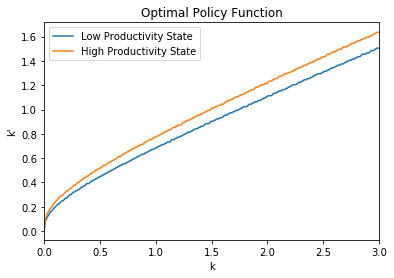

In [8]:
# Plot the optimal policy function
ax = pd.DataFrame(pol,
                  columns=['Low Productivity State','High Productivity State'],
                  index=controlSpace).plot(title = 'Optimal Policy Function')
ax.set_xlabel('k')
ax.set_ylabel("k'")

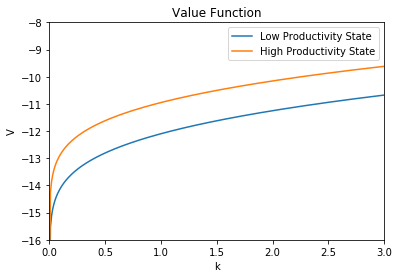

In [9]:
# Plot the Value Function
ax = pd.DataFrame(V,
             columns=['Low Productivity State',
                      'High Productivity State'],
             index=controlSpace).plot(title = 'Value Function',ylim=(-16,-8))
ax.set_xlabel('k')
ax.set_ylabel('V')